# Environment setting

In [1]:
!pip install tqdm

In [2]:
%pip install --upgrade --quiet --user google-cloud-aiplatform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 54.3 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
# Import libraries
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Import vertexai libraries
import vertexai
from vertexai.language_models import TextEmbeddingModel
from tqdm import tqdm

In [4]:
torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

device(type='cuda')

In [5]:
# Setting seed:

def set_seed_fun(seed_number: int):
    np.random.seed(seed_number)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed_number)
    if torch.cuda.is_available():
        torch.manual_seed(seed_number)
        torch.cuda.manual_seed(seed_number)
        torch.cuda.manual_seed_all(seed_number)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchark = False

set_seed_fun(42)
"""
We could also use pytorch_lightning package
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.5
    import pytorch_lightning as pl

pl.seed_everything(42)
"""

'\nWe could also use pytorch_lightning package\ntry:\n    import pytorch_lightning as pl\nexcept ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary\n    !pip install --quiet pytorch-lightning>=1.5\n    import pytorch_lightning as pl\n\npl.seed_everything(42)\n'

In [6]:
# Load Dataset
df = pd.read_csv("final_combined_dataset.csv")

In [7]:
# Prepare data
X = df['Text'].values.astype(str)
y = (df['Label'] == 'fake').astype(int).values


In [8]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Embedding

In [9]:
# Modified function to process texts in batches

def generate_vertex_embeddings(texts, model, task_type="CLASSIFICATION", output_dimensionality=768, batch_size=32):
    embeddings = []

    # Set up keyword arguments for model.get_embeddings()
    kwargs = dict(output_dimensionality=output_dimensionality) if output_dimensionality else {}

    # Initialize tqdm progress bar
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        # Slicing might return a string if the batch size is 1 and it's the last element
        batch_texts = texts[i:i + batch_size]

        # Ensure that batch_texts is always a list
        if isinstance(batch_texts, str):
            batch_texts = [batch_texts]
        elif isinstance(batch_texts, np.ndarray):  # Handle np.array slice which might not be a list
            batch_texts = batch_texts.tolist()

        try:
            # Get the embeddings in batches, passing the kwargs to control output_dimensionality if set
            embedding_response = model.get_embeddings(batch_texts, **kwargs)

            # Extract the embedding values from each text in the batch
            for embedding in embedding_response:
                embeddings.append(embedding.values)

        except Exception as e:
            print(f"Error processing batch {i}: {e}")

    # Ensure embeddings list is not empty before attempting to concatenate
    if embeddings:
        return np.vstack(embeddings)
    else:
        raise ValueError("No valid embeddings were generated.")


In [10]:
#####################################
# benchmark beginning for embedding #
#####################################
time_start_embed = time.perf_counter()

In [11]:
# Initialize the Vertex AI TextEmbeddingModel
embedding_model = TextEmbeddingModel.from_pretrained("text-embedding-004")

In [12]:
# Generate embeddings using Vertex AI's text-embedding-004
X_train_embeddings = generate_vertex_embeddings(X_train, embedding_model)
X_val_embeddings = generate_vertex_embeddings(X_val, embedding_model)
X_test_embeddings = generate_vertex_embeddings(X_test, embedding_model)

Generating Embeddings: 100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


In [13]:
#####################################
# benchmark ending for embedding    #
#####################################
time_end_embed = time.perf_counter()

# Training part

## Class functions

Definition of functions to:
- Transform a data set into the good format
- create a simple neural network architecture
- create a funtion to transform seconds into a list of (hours, minutes, seconds)

In [14]:
# Define a Dataset class for PyTorch
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)



In [15]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(p=0.6)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.dropout2 = nn.Dropout(p=0.6)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [16]:
def sec2hms(ss):
	(hh, ss)=divmod(ss, 3600)
	(mm, ss)=divmod(ss, 60)
	return (hh, mm, ss)

## Training function

Definition of the training function.

In [17]:
# Function to train the model
def train_model(X_train, y_train, X_val, y_val, input_size):
    train_dataset = NewsDataset(X_train, y_train)
    val_dataset = NewsDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = SimpleNN(input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

    num_epochs = 30
    best_val_loss = float('inf')
    patience = 2
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
           print("Early stopping")
           break

    return model

## Model initialization

## Training

In [18]:
#####################################
# benchmark beginning for modeling  #
#####################################
time_start_model = time.perf_counter()

In [19]:
input_size = 768

In [20]:
# Set up the device (cuda, mps, or cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [21]:
# Train the model
model = train_model(X_train_embeddings, y_train, X_val_embeddings, y_val, input_size)


Epoch 1/30, Validation Loss: 0.6800526020138763
Epoch 2/30, Validation Loss: 0.49980796284453816
Epoch 3/30, Validation Loss: 0.29195631035538605
Epoch 4/30, Validation Loss: 0.25051826134670613
Epoch 5/30, Validation Loss: 0.23526633686797563
Epoch 6/30, Validation Loss: 0.22809337079524994
Epoch 7/30, Validation Loss: 0.21921591218127762
Epoch 8/30, Validation Loss: 0.21645016032595968
Epoch 9/30, Validation Loss: 0.21559998479693435
Epoch 10/30, Validation Loss: 0.21055186609196108
Epoch 11/30, Validation Loss: 0.2079056588023208
Epoch 12/30, Validation Loss: 0.20552811078553976
Epoch 13/30, Validation Loss: 0.20401118002658666
Epoch 14/30, Validation Loss: 0.20680939215560293
Epoch 15/30, Validation Loss: 0.20288865891999977
Epoch 16/30, Validation Loss: 0.2053678486236306
Epoch 17/30, Validation Loss: 0.20263880110064217
Epoch 18/30, Validation Loss: 0.20184113795674125
Epoch 19/30, Validation Loss: 0.19961376349593318
Epoch 20/30, Validation Loss: 0.19801714115364608
Epoch 21/30,

In [22]:
#####################################
# benchmark ending for modeling     #
#####################################
time_end_model = time.perf_counter()

## Evaluating

In [23]:
# Evaluate the model on the test set
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch in torch.tensor(X_test_embeddings, dtype=torch.float32).to(device):
        outputs = model(X_batch.unsqueeze(0))
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted.cpu().numpy()[0])


In [24]:
# Evaluate performance
acc = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=["real", "fake"])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc}")
print(f"Classification Report:{class_report}")
print(f"Confusion Matrix:{conf_matrix}")


Accuracy: 0.9354956268221575
Classification Report:              precision    recall  f1-score   support

        real       0.94      0.94      0.94      1413
        fake       0.94      0.93      0.93      1331

    accuracy                           0.94      2744
   macro avg       0.94      0.94      0.94      2744
weighted avg       0.94      0.94      0.94      2744

Confusion Matrix:[[1328   85]
 [  92 1239]]


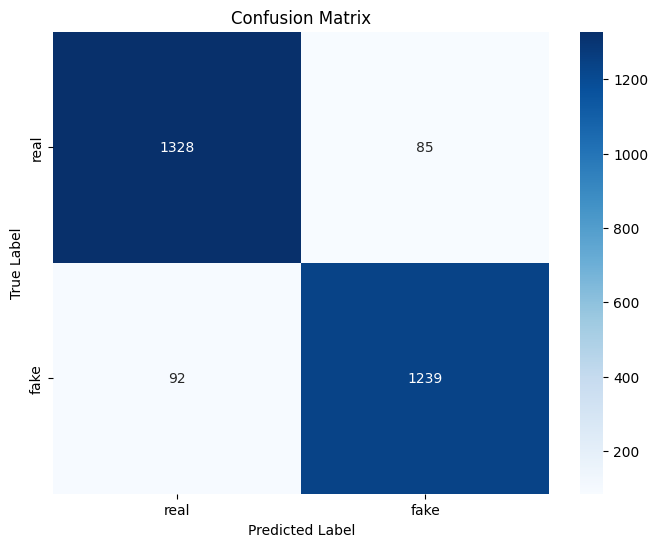

In [25]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## Benchmark results

In [26]:
#####################################
#          Benchmark results        #
#####################################
# calculating the performances
embedding_duration = time_end_embed - time_start_embed
modeling_duration = time_end_model - time_start_model

# formating
embedding_duration_hms = sec2hms(embedding_duration)
modeling_duration_hms = sec2hms(modeling_duration)

# printing the embedding and modeling performances

print(f'Embedding duration : {embedding_duration_hms[0]:.0f}:{embedding_duration_hms[1]:.0f}:{embedding_duration_hms[2]:.3f}')
print(f'Modeling duration : {modeling_duration_hms[0]:.0f}:{modeling_duration_hms[1]:.0f}:{modeling_duration_hms[2]:.3f}')

Embedding duration : 0:2:46.852
Modeling duration : 0:0:27.167


In [27]:
## we should write a function with an if else condition for when a drive is in and where there's not
# Save the trained model to Google Drive
# final_model_path = '/content/drive/My Drive/fake_news_model_roberta3.pth'
# torch.save(model.state_dict(), final_model_path)
# print(f"Model saved to: {final_model_path}")
torch.save(model.state_dict(), "model.tar")
